In [188]:
#loading modules 
import os 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from statistics import mode

import matplotlib.pyplot as plt

This project tries to analyze the breast cancer dataset as used in Royston and Altman "External validation of a Cox prognostic model: principles and methods", also called Rotterdam data set.

In [189]:
df = pd.read_csv("C:\\Users\Leon\\Desktop\\Data-Science\\Breast_cancer_singh\\gbsg.csv")
df.head(10)

,Unnamed: 0,pid,age,meno,size,grade,nodes,pgr,er,hormon,rfstime,status
0,1,132,49,0,18,2,2,0,0,0,1838,0
1,2,1575,55,1,20,3,16,0,0,0,403,1
2,3,1140,56,1,40,3,3,0,0,0,1603,0
3,4,769,45,0,25,3,1,0,4,0,177,0
4,5,130,65,1,30,2,5,0,36,1,1855,0
5,6,1642,48,0,52,2,11,0,0,0,842,1
6,7,475,48,0,21,3,8,0,0,0,293,1
7,8,973,37,0,20,2,9,0,0,1,42,0
8,9,569,67,1,20,2,1,0,0,1,564,1
9,10,1180,45,0,30,2,1,0,0,0,1093,1


Since this dataset was collected with the purpose of prediciting survival rates in patient populations, we will therefore cut the variable rfstime out of our dataset for now, since this would need a more complicated model(the authors used a so called cox model). However we want to use this dataset to learn how to deal with categorical variables and since time will then be cut out for now, we will use the status variable as our target. Later we want to try and implement the paper model.
For now we have the following variables:
<ol>
  <li>pid is the patient identifier and can be dropped since this is only interesting in production
  <li> age is the age of the patient
  <li>meno meaning menopause and whether or not the patient has hit the menopause yet, categorical variable
  <li>size is the size of the growth in milimeters
  <li>grade meaning the severity of the cancer with one being benign growth and higher meaning malignant
  <li>nodes are the number of infected lymph nodes in the patients tissue
  <li>pgr is the concentration of progesteron a growth hormone in the patients blood
  <li>er is the concentration of estrogen
  <li>hormon describes whether or not a patient is prescribed hormone therapy
  <li>rfstime defines the time between reoccurence and or death of the patient with the cancer
  <li>status describes whether the patient has recovered is in remission or is dead
</ol>
First we want to explore the dataset a bit and check for the integrity of the values presented, for example are the values in the respected range we want them to be in.

mean age 53.052478134110785 modal age 47
mean nodes 5.010204081632653 modal nodes 1
mean size 29.32944606413994 modal size 30
mean pgr 109.99562682215743 modal pgr 0
mean er 96.25218658892128 modal er 0
mean grade 2.116618075801749 modal grade 2


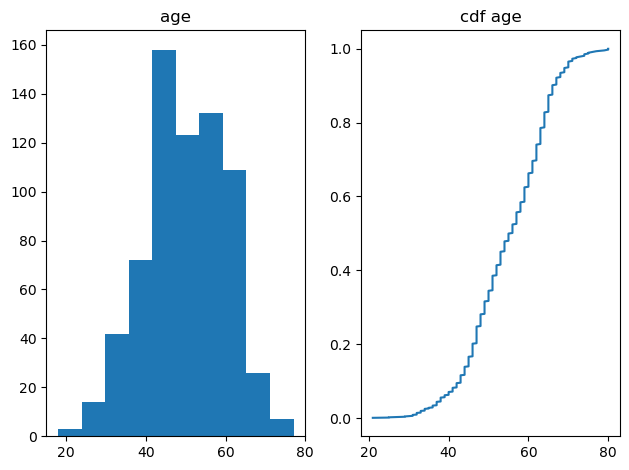

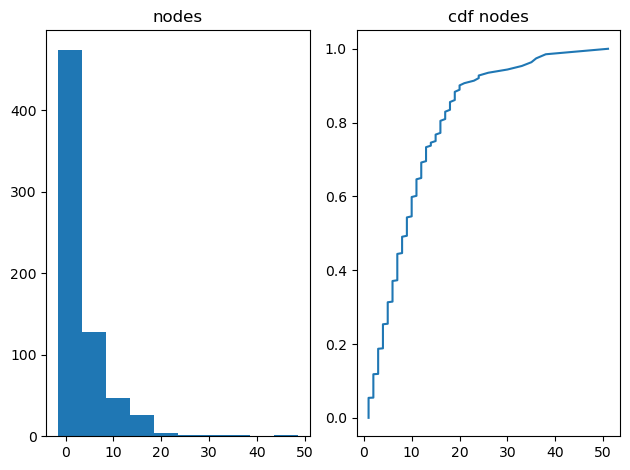

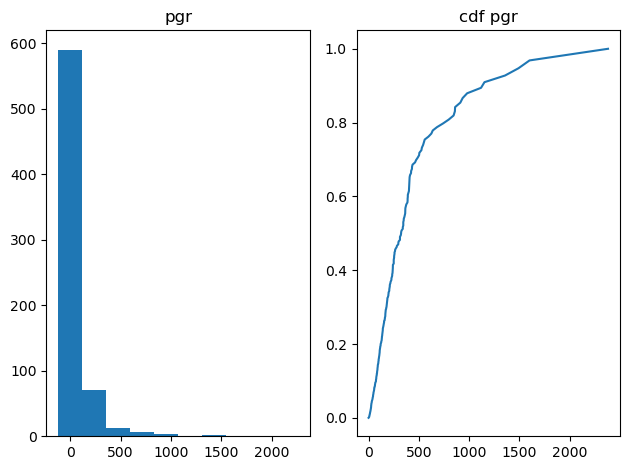

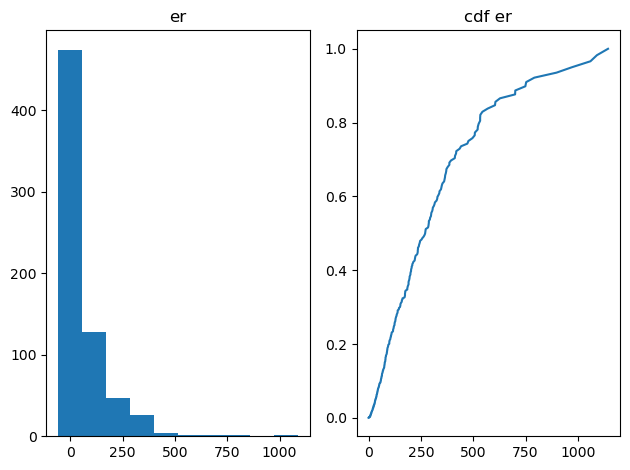

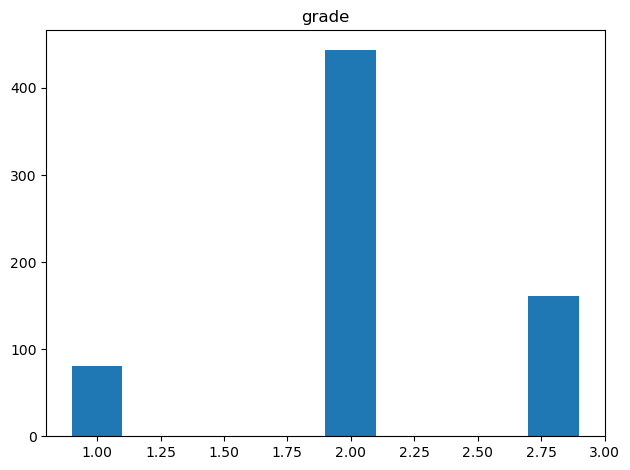

In [190]:
# plotting histograms

counts_age, bins_age = np.histogram(df['age'])
counts_size, bins_size = np.histogram(df['size'])
counts_nodes, bins_nodes = np.histogram(df['nodes'])
counts_pgr, bins_pgr = np.histogram(df['pgr'])
counts_er, bins_er = np.histogram(df['er'])
counts_grade, bins_grade = np.histogram(df['grade'])


age = list(df['age'])
age.sort()

size = list(df['size'])
size.sort()

nodes = list(df['nodes'])
nodes.sort()

pgr = list(df['pgr'])
pgr.sort()

er = list(df['er'])
er.sort()

grade = list(df['grade'])
grade.sort()


cdf_age = np.cumsum(age)/sum(age)
cdf_size = np.cumsum(size)/sum(size)
cdf_nodes = np.cumsum(nodes)/sum(nodes)
cdf_pgr = np.cumsum(pgr)/sum(pgr)
cdf_er = np.cumsum(er)/sum(er)


fig, ax = plt.subplots(1,2)
ax[0].hist(bins_age[:-1], bins_age, weights=counts_age, align ='left')
ax[0].set_title('age')
ax[1].plot(age,cdf_age)
ax[1].set_title('cdf age')
fig.tight_layout()

fig, ax = plt.subplots(1,2)
ax[0].hist(bins_nodes[:-1], bins_nodes, weights=counts_nodes, align='left')
ax[0].set_title('nodes')
ax[1].plot(nodes,cdf_nodes)
ax[1].set_title('cdf nodes')
fig.tight_layout()


fig, ax = plt.subplots(1,2)
ax[0].hist(bins_pgr[:-1], bins_pgr, weights=counts_pgr, align='left')
ax[0].set_title('pgr')
ax[1].plot(pgr,cdf_pgr)
ax[1].set_title('cdf pgr')
fig.tight_layout()

fig, ax = plt.subplots(1,2)
ax[0].hist(bins_er[:-1], bins_er, weights=counts_nodes, align='left')
ax[0].set_title('er')
ax[1].plot(er,cdf_er)
ax[1].set_title('cdf er')
fig.tight_layout()

fig, ax = plt.subplots(1,1)
ax.hist(bins_grade[:-1], bins_grade, weights=counts_grade, align='left')
ax.set_title('grade')
fig.tight_layout()


print('mean age', np.mean(df['age']) , 'modal age', mode(df['age']))
print('mean nodes', np.mean(df['nodes']) ,'modal nodes', mode(df['nodes']))
print('mean size', np.mean(df['size']),'modal size', mode(df['size']))
print('mean pgr', np.mean(df['pgr']),'modal pgr', mode(df['pgr']))
print('mean er', np.mean(df['er']),'modal er', mode(df['er']))
print('mean grade', np.mean(df['grade']),'modal grade', mode(df['grade']))





Since we want to use this project to learn about multicalss classification we are going to plot the respective variables against the severity of the cancer, which here in our data set is called grade. We also added the median values of the data.
From the cumulative distribution function, as well as the histogram we can observe the following trends.
<ol>
  <li> As expected the most likely time at which cancer represents itself is rather late in life. Which is expected for this type of cancer 
  <li> The number of nodes is around 1, which also makes sense given the most likely value for "grade" is 2 and this means that the cancer hasn't spread yet
  <li> The progresteron concentration is around 110 fmol/l with a modal value of 0, however the histogram plot implies a fat tail distribution, in turn implying the greater genetic variety of the cancer 
  <li> estrogen concentration is around 96fmol/l, also with a modal value of 0, 
  <li> the mean and the modal value of the grade is 2, as discussed beforehand this mean most of the patients have cancer that hasn't spread 

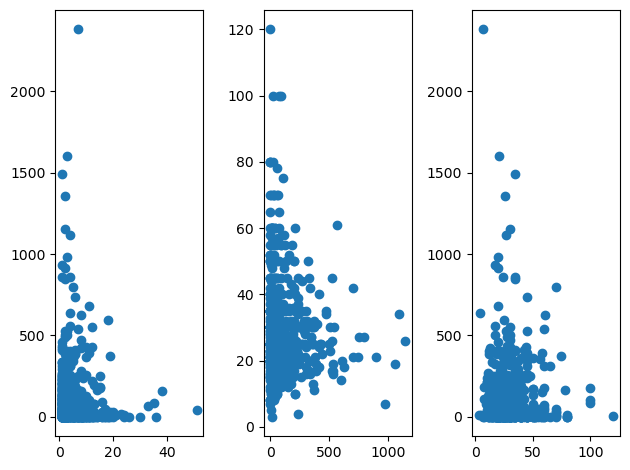

In [191]:
#QQ plots of the analysis

# for age vs nodes
fig , ax = plt.subplots(1,3)
ax[0].scatter(df['nodes'], df['pgr'])
ax[0].
ax[1].scatter(df['er'], df['size'])
ax[2].scatter(df['size'], df['pgr'])
fig.tight_layout()

